In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.metrics import MeanIoU
from glob import glob
import prepareVOC12 as voc

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 4
NUM_CLASSES = 21
DATA_DIR = "./VOC12"
NUM_TRAIN_IMAGES = 1500
NUM_VAL_IMAGES = 300
single_channel_dict = voc.single_channel_dict

train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "train_label/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "train_label/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES]

def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])

        def apply_rgb_to_one_hot(image_np):
            one_hot_map = voc.label_to_onehot_ResUnet(image_np, voc.class_dict)
            return one_hot_map

        image = tf.py_function(
            func=apply_rgb_to_one_hot,
            inp=[image],
            Tout=tf.float32
        )
        image.set_shape([IMAGE_SIZE, IMAGE_SIZE, len(voc.class_dict)])

    else:
        image = tf.image.decode_jpeg(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 21), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 224, 224, 21), dtype=tf.float32, name=None))>


In [3]:
def decoder_block_simple(input_tensor, filters, strides=(2, 2)):
    x = layers.Conv2DTranspose(filters, kernel_size=3, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def resnet_unet_simple(input_shape, num_classes):
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)

    # Encoder
    encoder_output1 = base_model.get_layer('conv1_relu').output
    encoder_output2 = base_model.get_layer('conv2_block3_out').output
    encoder_output3 = base_model.get_layer('conv3_block4_out').output
    encoder_output5 = base_model.get_layer('conv5_block3_out').output

    # Decoder
    decoder_output1 = decoder_block_simple(encoder_output5, 256)
    decoder_output1 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output1)
    decoder_output1 = layers.Concatenate()([encoder_output3, decoder_output1])
    # decoder_output1 = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same', activation='relu')(decoder_output1)

    decoder_output2 = decoder_block_simple(decoder_output1, 256)
    # decoder_output2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output1)
    decoder_output2 = layers.Concatenate()([encoder_output2, decoder_output2])
    decoder_output2 = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same', activation='relu')(decoder_output2)


    decoder_output2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output2)
    decoder_output2 = layers.Concatenate()([encoder_output1, decoder_output2])
    decoder_output2 = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(decoder_output2)
    
    # Final Convolutional Layer
    output = layers.Conv2D(num_classes, kernel_size=(1, 1), activation='softmax')(decoder_output2)

    # Model
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Create the model
input_shape = (224, 224, 3)
num_classes = 21

model = resnet_unet_simple(input_shape, num_classes)

Epoch 1/4
375/375 [==============================] - 153s 387ms/step - loss: 0.7831 - accuracy: 0.7884 - precision: 0.8423 - val_loss: 0.6868 - val_accuracy: 0.7871 - val_precision: 0.8164
Epoch 2/4
375/375 [==============================] - 142s 379ms/step - loss: 0.4420 - accuracy: 0.8632 - precision: 0.8914 - val_loss: 0.7162 - val_accuracy: 0.7798 - val_precision: 0.8029
Epoch 3/4
375/375 [==============================] - 144s 384ms/step - loss: 0.3918 - accuracy: 0.8725 - precision: 0.8960 - val_loss: 0.8674 - val_accuracy: 0.7613 - val_precision: 0.7707
Epoch 4/4
375/375 [==============================] - 143s 382ms/step - loss: 0.4081 - accuracy: 0.8680 - precision: 0.8917 - val_loss: 0.8214 - val_accuracy: 0.7864 - val_precision: 0.7779


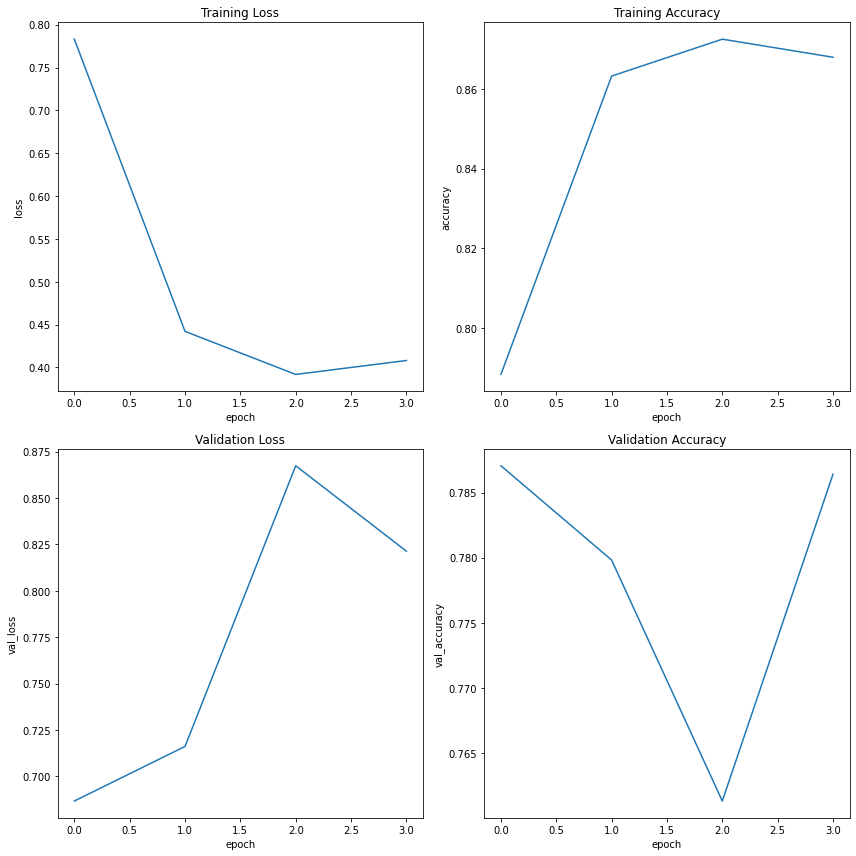

In [4]:
loss = keras.losses.CategoricalCrossentropy()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00015),
    loss=loss,
    metrics=["accuracy", keras.metrics.Precision()],
)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=4, batch_size= BATCH_SIZE)

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Training Loss
axes[0, 0].plot(history.history["loss"])
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_ylabel("loss")
axes[0, 0].set_xlabel("epoch")

# Training Accuracy
axes[0, 1].plot(history.history["accuracy"])
axes[0, 1].set_title("Training Accuracy")
axes[0, 1].set_ylabel("accuracy")
axes[0, 1].set_xlabel("epoch")

# Validation Loss
axes[1, 0].plot(history.history["val_loss"])
axes[1, 0].set_title("Validation Loss")
axes[1, 0].set_ylabel("val_loss")
axes[1, 0].set_xlabel("epoch")

# Validation Accuracy
axes[1, 1].plot(history.history["val_accuracy"])
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_ylabel("val_accuracy")
axes[1, 1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [5]:
with tf.device('/CPU:0'):
    history = model.predict(val_dataset.take(30), batch_size=4)

30/30 [==============================] - 27s 864ms/step


In [6]:
y_pred = []
for onehot in history:
    y_pred.append(voc.onehot_to_label(onehot, voc.class_dict))

y_pred = np.array(y_pred).astype('uint8')

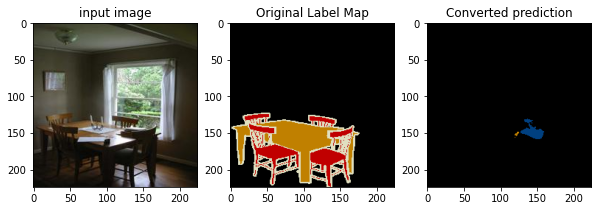

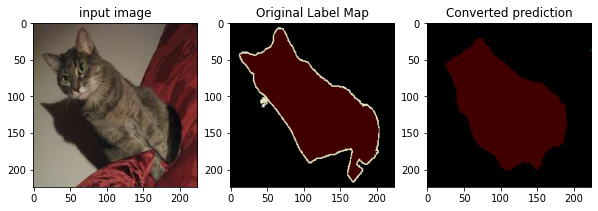

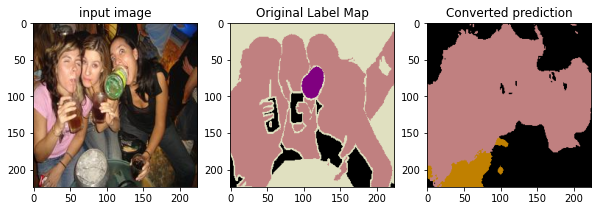

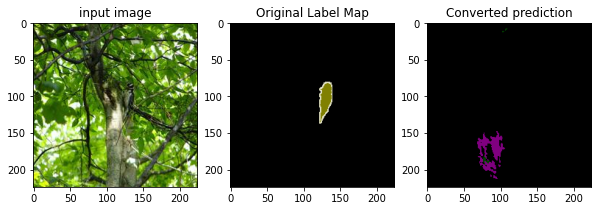

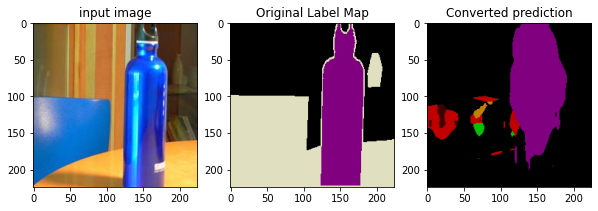

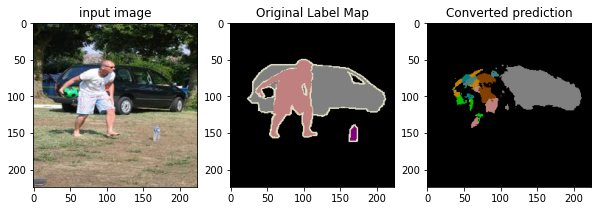

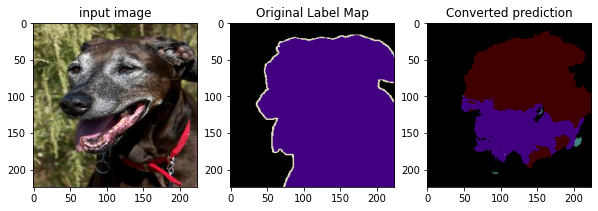

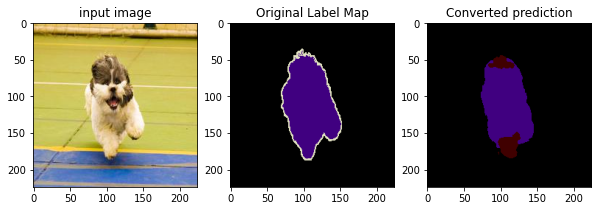

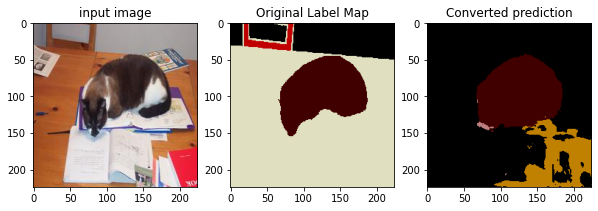

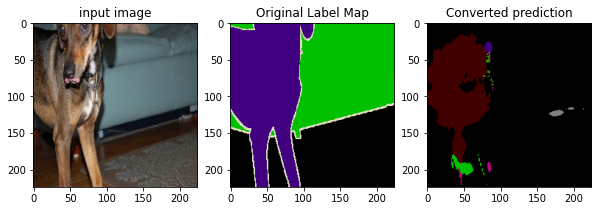

In [12]:
from PIL import Image
# index = 9
for index in range(40,50):
    image = Image.open(val_images[index])
    mask = Image.open(val_masks[index])
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(image)
    axs[0].set_title('input image')
    axs[1].imshow(mask)
    axs[1].set_title('Original Label Map')
    axs[2].imshow(y_pred[index])
    axs[2].set_title('Converted prediction')

In [8]:
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / np.prod(y_true.shape)

def mean_accuracy(y_true, y_pred, num_classes):
    class_accuracies = np.zeros(num_classes)
    for i in range(num_classes):
        mask = y_true == i
        if np.sum(mask) > 0:
            class_accuracies[i] = np.sum((y_pred[mask] == y_true[mask])) / np.sum(mask)
    return np.mean(class_accuracies)

def mean_iou(y_true, y_pred, num_classes):
    class_ious = np.zeros(num_classes)
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        if union > 0:
            class_ious[i] = intersection / union
    return np.nanmean(class_ious)

def frequency_weighted_iou(y_true, y_pred, num_classes):
    total_pixels = 0
    weighted_iou_sum = 0
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        total_pixels += np.sum(y_true == i)
        if np.sum(y_true == i) > 0:
            weighted_iou_sum += (np.sum(y_true == i) * (intersection / union))
    return weighted_iou_sum / total_pixels

In [9]:
y_pred_labels = y_pred[:100]
y_pred_labels = np.array(y_pred_labels).astype('uint8')

y_val_labels = []
for i in range(100):
    mask_path = train_masks[i]
    mask = read_image(mask_path, mask=True)
    y_val_labels.append(mask)

y_val = []
for onehot in y_val_labels:
    y_val.append(voc.onehot_to_label(onehot, voc.class_dict))

y_val = np.array(y_val).astype('uint8')


# y_pred_labels = np.expand_dims(y_pred_labels, axis=-1)
print(y_pred_labels.shape)
print(y_val.shape)
    
pa = pixel_accuracy(y_val, y_pred_labels)
ma = mean_accuracy(y_val, y_pred_labels, num_classes=21)
miou = mean_iou(y_val, y_pred_labels, num_classes=21)
fwiou = frequency_weighted_iou(y_val, y_pred_labels, num_classes=21)

print(f"Pixel Accuracy: {pa:.4f}")
print(f"Mean Accuracy: {ma:.4f}")
print(f"Mean IoU: {miou:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")

(100, 224, 224, 3)
(100, 224, 224, 3)
Pixel Accuracy: 0.7279
Mean Accuracy: 0.0410
Mean IoU: 0.0350
Frequency Weighted IoU: 0.7354
